# Google Colab 한글 폰트 설치

In [1]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

Selecting previously unselected package fonts-nanum.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인

['NanumBarunGothic'] 11.0


- 테스트

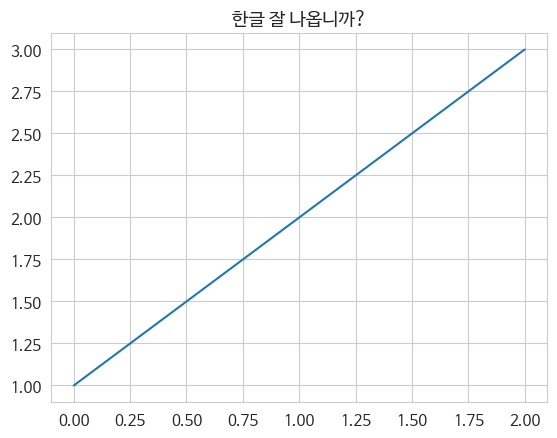

In [9]:
plt.plot([1, 2, 3])
plt.title("한글 잘 나옵니까?")
plt.show()

# Google Colab과 드라이브 연동

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 데이터 가져오기

In [12]:
import pandas as pd
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/2024_2025/imbank/머신러닝/data/'
X_train = pd.read_csv(DATA_PATH + "penguin_clf_X_train.csv")
X_test = pd.read_csv(DATA_PATH + "penguin_clf_X_test.csv")
y_train = pd.read_csv(DATA_PATH + "penguin_clf_y_train.csv")

In [13]:
X_train.head(1)

,ID,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,28,Biscoe,40.5,17.9,187.0,3200.0,female,2007


In [14]:
X_test.head(1)

,ID,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,31,Dream,39.5,16.7,178.0,3250.0,female,2007


In [15]:
y_train.head(1)

,species
0,Adelie


# 데이터 가공

## ID 추출 및 제거

In [16]:
X_train_id = X_train['ID']
X_test_id = X_test['ID']

In [17]:
X_train = X_train.drop('ID', axis=1)
X_train.head(1)

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Biscoe,40.5,17.9,187.0,3200.0,female,2007


In [18]:
X_test = X_test.drop('ID', axis=1)
X_test.head(1)

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Dream,39.5,16.7,178.0,3250.0,female,2007


## 결측치 체크

In [19]:
X_train.isnull().sum()

,0
island,0
bill_length_mm,0
bill_depth_mm,0
flipper_length_mm,0
body_mass_g,0
sex,0
year,0


In [20]:
X_test.isnull().sum()

,0
island,0
bill_length_mm,0
bill_depth_mm,0
flipper_length_mm,0
body_mass_g,0
sex,0
year,0


# 컬럼 분리
- 범주형 컬럼명과 수치형 컬럼명으로 분리

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   island             233 non-null    object 
 1   bill_length_mm     233 non-null    float64
 2   bill_depth_mm      233 non-null    float64
 3   flipper_length_mm  233 non-null    float64
 4   body_mass_g        233 non-null    float64
 5   sex                233 non-null    object 
 6   year               233 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 12.9+ KB


In [23]:
import numpy as np

cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'year']

In [25]:
num_cols.remove('year')
num_cols

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# 데이터셋 분리

In [27]:
type(y_train)

pandas.core.frame.DataFrame

In [28]:
y_train['species'].value_counts(normalize=True)

,proportion
species,
Adelie,0.420601
Gentoo,0.386266
Chinstrap,0.193133


In [30]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train['species'],
    stratify = y_train['species'],
    test_size=0.3,
    random_state=42
)

X_tr.shape, X_val.shape, y_tr.shape, y_val.shape

((163, 7), (70, 7), (163,), (70,))

# 파이프라인(Pipeline) 모델 생성
- 암기

In [33]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# 피처 엔지니어링
# 적절하게 각 피처(컬럼)을 머신러닝 알고리즘에 맞게 가공
column_transformer = ColumnTransformer([
    ("scaler", StandardScaler(), num_cols),
    ("ohd_encoder", OneHotEncoder(), cat_cols),
], remainder="passthrough", force_int_remainder_cols=False)

pipeline = Pipeline([
    ("preprocessing", column_transformer),
    ("clf", RandomForestClassifier(max_depth = 2, random_state=42))
])

# 훈련데이터 학습
pipeline.fit(X_tr, y_tr)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('ohd_encoder',
                                                  OneHotEncoder(),
                                                  ['island', 'sex'])])),
                ('clf', RandomForestClassifier(max_depth=2, random_state=42))])

## 모형 평가

In [34]:
def get_score(model, X_tr, X_val, y_tr, y_val):
    tr_pred = model.predict(X_tr) # 만약 확률로 구할시, predict_proba()[:, 1]
    # print(tr_pred)
    val_pred = model.predict(X_val)
    tr_score = f1_score(y_tr, tr_pred, average="macro")
    val_score = f1_score(y_val, val_pred, average="macro")
    return f"train: {tr_score}, validation: {val_score}"

get_score(pipeline, X_tr, X_val, y_tr, y_val)

'train: 0.9844163939535608, validation: 1.0'

# 예측

In [36]:
final_preds = pipeline.predict(X_test)
result = pd.DataFrame({
    "ID" : X_test_id,
    "preds" : final_preds
})

result

,ID,preds
0,31,Adelie
1,321,Chinstrap
2,80,Adelie
3,203,Gentoo
4,64,Adelie
...,...,...
95,21,Adelie
96,8,Adelie
97,217,Gentoo
98,100,Chinstrap
